<a href="https://colab.research.google.com/github/mkorlyakova/test_pallet/blob/main/%D0%AD%D0%BA%D1%81%D0%BF%D0%B5%D1%80%D0%B8%D0%BC%D0%B5%D0%BD%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ответы  на запрос "товары на полке распознать":

https://www.datanomics.ru/artciles/raspoznavanie-tovara-na-polke/

https://habr.com/ru/company/true_engineering/blog/416123/




# Инсталяция рабочих пакетов

мой GITHub репозиторий для подключения картинок

In [2]:
# Clone the entire repo.
!git clone https://github.com/mkorlyakova/test_pallet.git
!ls

Cloning into 'test_pallet'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 64 (delta 33), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (64/64), done.
sample_data  test_pallet


Библиотека для чтения архива

In [3]:
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -q -U libarchive


Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 160980 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.2.2-3.1ubuntu0.6_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.2.2-3.1ubuntu0.6) ...
Setting up libarchive-dev:amd64 (3.2.2-3.1ubuntu0.6) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 163kB 11.6MB/s 


Импорт модулей:
 - общие : numpy
 - обработка файлов : glob, libarchive, os
 - чтение и разбор данных : json, cv2, shapely.geometry
 - отрисовка графиков : matplotlib
 - обучение : sklearn, tensorflow
 

In [4]:
import numpy as np
import pandas as pd
from glob import glob
import libarchive

import libarchive.public
import os


import json

import cv2 as cv
import matplotlib.pyplot as plt

In [5]:
from shapely.geometry import Polygon

In [6]:
from sklearn.cluster import DBSCAN
# кластеранализ


In [7]:
import tensorflow as tf




## Подключение и чтение информации

Задаю пути к рабочим каталогам

In [8]:
# отсюда берем архив
path = '/content/test_pallet/задание sm 20210309.zip'

In [9]:
# тут распакум данные
path_image = '/content/image_json/'

## Читаем и распаковываем

In [10]:
# проверка рабочего каталога
if os.path.exists(path_image) == False: 
    os.mkdir('..'+path_image)
# переход в рабочий каталог    
os.chdir('..'+path_image)
#  открываем архив
with open(path, 'rb') as f:
    for entry in libarchive.public.memory_pour(f.read()):
        print(entry)
# вернулись в основной каталог
os.chdir('/content')

ArchiveEntry<NAME=[задание.docx] SIZE=(216265)>
ArchiveEntry<NAME=[__MACOSX/._задание.docx] SIZE=(590)>
ArchiveEntry<NAME=[24d8bfc3-af64-4525-9dfc-bab6d1df6cbe_0.jpeg] SIZE=(1599642)>
ArchiveEntry<NAME=[__MACOSX/._24d8bfc3-af64-4525-9dfc-bab6d1df6cbe_0.jpeg] SIZE=(268)>
ArchiveEntry<NAME=[24d8bfc3-af64-4525-9dfc-bab6d1df6cbe_0.jpeg.json] SIZE=(11812)>
ArchiveEntry<NAME=[__MACOSX/._24d8bfc3-af64-4525-9dfc-bab6d1df6cbe_0.jpeg.json] SIZE=(212)>
ArchiveEntry<NAME=[2df842e3-2a23-46f0-8ef5-4e4806cfb92e_0.jpeg] SIZE=(1673789)>
ArchiveEntry<NAME=[__MACOSX/._2df842e3-2a23-46f0-8ef5-4e4806cfb92e_0.jpeg] SIZE=(268)>
ArchiveEntry<NAME=[2df842e3-2a23-46f0-8ef5-4e4806cfb92e_0.jpeg.json] SIZE=(8593)>
ArchiveEntry<NAME=[__MACOSX/._2df842e3-2a23-46f0-8ef5-4e4806cfb92e_0.jpeg.json] SIZE=(212)>
ArchiveEntry<NAME=[47532b0d-96bc-4589-983f-1e3e5700626a_1.jpeg] SIZE=(1543451)>
ArchiveEntry<NAME=[__MACOSX/._47532b0d-96bc-4589-983f-1e3e5700626a_1.jpeg] SIZE=(268)>
ArchiveEntry<NAME=[47532b0d-96bc-4589-983f-1e3

Списки файлов аннотаций и изображений отдельно:

In [11]:
json_arr = glob(path_image+'/*.json')  # список имен аннотаций
jpeg_arr = glob(path_image+'/*.jpeg')  # список имен картинок
print('число аннотаций :',len(json_arr))
print('число картинок :',len(jpeg_arr))

число аннотаций : 5
число картинок : 5


количество совпадает - ок!


Проверим разметку.

In [12]:
# визуализация рамки
def rect(img, boundBox, text="", colors_ = (255,255,255), thick = 20):
  '''
  Рисуем ранку на изображении img (по OpenCV2), 
  boundBox - углы рамка (X,Y левого верхнего угла,  X, Y правого нижнего угла), 
  text="" - текст для рамки, 
  colors_ = (255,255,255) - цвет для рамки, 
  thick = 20 -  толщина рамки или если (-1), то рисуем сплошную залитую рпамку
  '''
  x1r,y1r,x2r,y2r = boundBox  # читаем координаты углов
  # размер изображения
  s = img.shape
  # координаты в целые
  x1 = int(np.ceil(x1r)) 
  y1 = int(np.ceil(y1r))
  x2 = int(np.ceil(x2r)) 
  y2 = int(np.ceil(y2r))
  #print(x1,y1,x2,y2)
  #print(colors_)
  # рамка
  cv.rectangle(img, (x1,y1), (x2,y2), colors_, thick)
  # текст рамки
  l = 0
  if text != "":
    l = len(text)*14
  cv.rectangle(img,(x1,y1-22),(x1+l,y1),colors_,-1)
  font = cv.FONT_HERSHEY_SIMPLEX
  cv.putText(img,text,(x1,y1), font, 0.8,(0,0,0),1,cv.LINE_AA)

Посмотрим на разметку по аннотации

In [13]:
def annotation_read(image_name, json_arr):
  '''
  поиск и чтение аннотаций
  image_name - имя картинки, 
  json_arr - список имен файлов аннотаций

  вернем: список списков координат рамок box_bound

  '''
  k = json_arr.index(image_name+'.json')

  print('картинка : ',json_arr[k])
  # читаем картинку
  image = cv.imread(image_name)
  image_shape.append(image.shape)
  # читаем аннотацию
  with open(json_arr[k]) as f:
    decoded_hand = json.load(f)
    box_bound = decoded_hand['boxes']
    #print(box_bound)
    print('число рамок на картинке: ',len(box_bound))
  return  box_bound, image

картинка :  /content/image_json/2df842e3-2a23-46f0-8ef5-4e4806cfb92e_0.jpeg.json
число рамок на картинке:  64


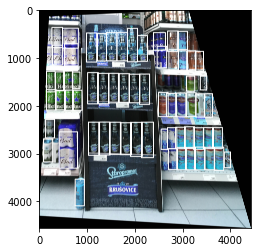

картинка :  /content/image_json/f3629039-af8c-4072-b956-32b77b762f0d_4.jpeg.json
число рамок на картинке:  89


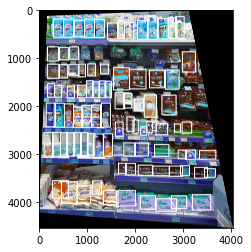

картинка :  /content/image_json/24d8bfc3-af64-4525-9dfc-bab6d1df6cbe_0.jpeg.json
число рамок на картинке:  88


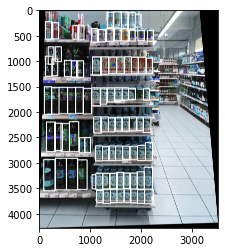

картинка :  /content/image_json/d3518d48-72d7-47f8-b334-4e61244c4378_0.jpeg.json
число рамок на картинке:  54


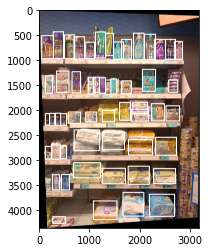

картинка :  /content/image_json/47532b0d-96bc-4589-983f-1e3e5700626a_1.jpeg.json
число рамок на картинке:  65


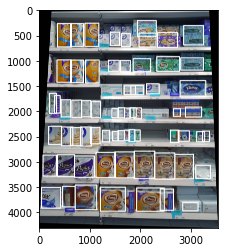

размер по У: минимальный =  4278   : максимальный  =  4553
размер по х: минимальный =  3196   : максимальный  =  4432
число каналов:   3
число объектов на картинках: минимальный =  54   : максимальный  =  89   : средний : 72.0


In [14]:
image_shape = []
numb_bound = []

# листаем список имен файлов картинок
for image_name in jpeg_arr:
  # картинке ставим в соответствие аннотацию
  box_bound, image = annotation_read(image_name, json_arr)
  numb_bound.append(len(box_bound))

  # по всем рамкам из аннотации
  for i_box in box_bound:
    # строим рамку на картинку
    rect(image,i_box,'')
  # выводим
  plt.imshow(image)
  plt.show()
# собрали размеры картинок    
image_shape = np.array(image_shape)

# резюме по данным
print('размер по У: минимальный = ',image_shape[:,0].min(),'  : максимальный  = ', image_shape[:,0].max())
print('размер по х: минимальный = ',image_shape[:,1].min(),'  : максимальный  = ', image_shape[:,1].max())
print('число каналов:  ',image_shape[0,2])
print('число объектов на картинках: минимальный = ',np.min(numb_bound),'  : максимальный  = ', np.max(numb_bound), '  : средний :',np.mean(numb_bound))




                  

## Результат анализа: 

 - картинок мало (5 штук)
 - размеры картинок разные : 
    - размер по У: минимальный =  4278   : максимальный  =  4553
    - размер по х: минимальный =  3196   : максимальный  =  4432
    - число каналов:   3 (все цветные)
 - видимых промахов детектора нет
 - число объектов в кадре : от 54 до 89
 - очевидно не все целевые объекты найдены (есть пропущеные объекты на полках)
 - визуально качество фоток близкое
 - каритнки ректифицированы


Задача: 
  
  - собрать в группы на полке

Особенности:
 - не все полки - полки (есть ряды на крючках)
 - не всегда полка на всю картинку по ширине (бывает 2 и более полок по ширине)
 - детектированные объекты на полках стоят более ли менее плотно
 - данных для обучения мало


 Гипотезы для обработки:

  1 - проверить кластеризацию по метрике
  
  2 - построить еще что-то из метрик ленинг(посмотреть на что-то не очень простое)




# Решение 1
кластерный анализ на основе DBSCAN (т.к.кластеры произвольной формы)

## Построим признаков:

- центроиды
- коробка из данных json (BoundingBox)
- Размеры по Х, У

Метрики: 
- метрика IoU
- метрика нормированное расстояние (расстояние между центрами *2/(диагональ 1+диагональ2))
- 

In [15]:
# Метрика 1 - IoU 
# https://en.wikipedia.org/wiki/Jaccard_index

def calculate_iou(box1, box2, w):
  '''
  Метрика по IoU - будем строить 1-IoU
  box1, box2 - координаты верхнего левого и нижнего правого угла рамок 1 и 2, 
  w - параметр расширения рамок
  вернем 1-IoU
  '''
  # читаем данные по рамке 1 и 2 
  x1,y1,x2,y2 = box1 
  x1 = x1 - w
  y1 = y1 - w
  x2 = x2 + w
  y2 = y2 + w
  coordinate_1 = [(x1,y1 ),(x1,y2),(x2,y2),(x2,y1)]
  x1,y1,x2,y2 = box2
  x1 = x1 - w
  y1 = y1 - w
  x2 = x2 + w
  y2 = y2 + w
  coordinate_2 = [(x1,y1),(x1,y2),(x2,y2),(x2,y1)]
  # cтроим полигоны
  polygon_1 = Polygon(coordinate_1)
  polygon_2 = Polygon(coordinate_2)
  # пересечение полигонов (в теории должно быть одинаково, но были отзывы, что ошибается)
  intersection1 = polygon_1.intersection(polygon_2).area
  intersection2 = polygon_2.intersection(polygon_1).area
  # строим пересечение
  if intersection1>intersection2:
    intersection = intersection1
  else:
    intersection = intersection2
  # строим общую площадь  - пересечение
  total_area = polygon_1.area + polygon_2.area - intersection
  if total_area > 0.0:
    return 1-float(intersection / total_area) # 1-IoU 
  return 1

def calculate_norm_dist(box1, box2):
  '''
  Метрика по эвклиду с нормализацией 
  пробуем соотнести расстояние между объектами и их размер
  будем строить (расстояние между центрами/(диагональ1+диагональ2))
  
  box1, box2 - координаты верхнего левого и нижнего правого угла рамок 1 и 2, 
  вернем (расстояние между центрами * 2/(диагональ1+диагональ2))
  '''
  cx1,cy1,x11,y11,x12,y12 = box1
  cx2,cy2,x21,y21,x22,y22 = box2
  # диагонали
  d1 = ((x11 - x12) ** 2 + (y11- y12) ** 2) ** 0.5
  d2 = ((x21 - x22) ** 2 + (y21- y22) ** 2) ** 0.5
  # расстояние между центрами
  c = ((cx1 - cx2) ** 2 + (cy1- cy2) ** 2 ) ** 0.5
  if (d1>0) & (d2>0):
    return c * 2 / (d1 + d2)
  else:
    return 10 ** 20   

def calculate_manhet_dist(box1, box2):
  '''
  Метрика по манхетенской форме с нормализацией 
  пробуем соотнести расстояние между объектами и их размер
  будем строить (расстояние между центрами/(диагональ1+диагональ2))
  
  box1, box2 - координаты верхнего левого и нижнего правого угла рамок 1 и 2, 
  вернем (расстояние между центрами * 2/(диагональ1+диагональ2))
  '''  
  cx1,cy1,x11,y11,x12,y12 = box1
  cx2,cy2,x21,y21,x22,y22 = box2
  # диагонали
  d1 = (np.abs(x11 - x12)  + np.abs(y11- y12) ) 
  d2 = (np.abs(x21 - x22) + np.abs(y21- y22) ) 
  # расстояние между центрами
  c = (np.abs(cx1 - cx2)   + np.abs(cy1- cy2) ) 
  # метрика
  if (d1>0) & (d2>0):
    return c #* 2 / (d1 + d2)
  else:
    return 10 ** 20


def calculate_y(box1, box2):
  '''
  Метрика по манхетенской форме с нормализацией 
  пробуем соотнести расстояние между объектами и их размер
  будем строить (расстояние между центрами/(диагональ1+диагональ2))
  
  box1, box2 - координаты верхнего левого и нижнего правого угла рамок 1 и 2, 
  вернем (расстояние между центрами * 2/(диагональ1+диагональ2))
  ''' 
  c = 10 ** 20 
  try:
    cx1,cy1,x11,y11,x12,y12 = box1
    cx2,cy2,x21,y21,x22,y22 = box2
    # расстояние между центрами
    d = (np.abs(y22 - y11) +np.abs(y21 - y12))/2
    if d>0:
      c = (np.abs(y12 - y22)) / d 
    else:
      c = 10 ** 20 
    return c
  except ValueError:
    print('ощибка')  
    return с  

def calculate_yx(box1, box2):
  '''
  Метрика по манхетенской форме с нормализацией 
  пробуем соотнести расстояние между объектами и их размер
  будем строить (расстояние между центрами/(диагональ1+диагональ2))
  
  box1, box2 - координаты верхнего левого и нижнего правого угла рамок 1 и 2, 
  вернем (расстояние между центрами * 2/(диагональ1+диагональ2))
  ''' 
  c = 10 ** 20 
  try:
    cx1,cy1,x11,y11,x12,y12 = box1
    cx2,cy2,x21,y21,x22,y22 = box2
    # расстояние между центрами
    d = (np.abs(y12 - y11) - np.abs(y21 - y22))/2
    if d>0:
      c = ((np.abs(y12 - y22)) + (np.abs(x12 - x21)) / d) 
      if c>3:
        c = 10 
    else:
      c = 10 ** 20 
    return c
  except ValueError:
    print('ощибка')  
    return с  


In [16]:
def my_metric(X, w):
  '''
  Метрики по данным Х с расширением рамок на w:
  Х - матрица Nxn - N - число примеров, n - число признаков
  w - целое число пикселей для расширения рамок (подбираем)

  вернем : 
  iou -  расстояния по IoU, 
  norm_dist - расстояния по Euqlid, 
  man_dist - расстояния по Manhatten
  '''
  # инициализация матриц расстояний по размеру данных Х
  iou = np.zeros((X.shape[0],X.shape[0])) # IoU  для всех со всеми - инициализация 0
  norm_dist = np.ones((X.shape[0],X.shape[0])) # нормированное расстояние - инициализация 1(пока)
  man_dist = np.ones((X.shape[0],X.shape[0])) # нормированное расстояние - инициализация 1(пока)
  y_dist = np.ones((X.shape[0],X.shape[0])) # нормированное расстояние - инициализация 1(пока)
  yx_dist = np.ones((X.shape[0],X.shape[0])) # нормированное расстояние - инициализация 1(пока)
  # считаем метрики по всем объектам со всеми
  for i in range(X.shape[0]-1):
    for j in range(i+1,X.shape[0]):
      # IoU
      iou[i,j] = calculate_iou( X[i,2:6],X[j,2:6], w)
      iou[j,i] =  iou[i,j]
      # Euqlid
      norm_dist[j,i] = calculate_norm_dist(X[i,:6],X[j,:6])
      norm_dist[i,j] = norm_dist[j,i]
      # Manhatten  
      man_dist[j,i] = calculate_manhet_dist(X[i,:6],X[j,:6])/X.shape[0]
      man_dist[i,j] = man_dist[j,i]
      y_dist[j,i] = calculate_y(X[i,:6],X[j,:6])
      y_dist[i,j] = y_dist[j,i]
      yx_dist[j,i] = calculate_yx(X[i,:6],X[j,:6])
      yx_dist[i,j] = yx_dist[j,i]
  #print(iou)
  return iou, norm_dist, y_dist,yx_dist, man_dist# norm_dist/np.mean(norm_dist), man_dist/np.mean(man_dist)


## Эксперимент с метриками

- построим признаки
- построим для каждой картинки метрики по my_metric(X, w)
- сделаем кластеранализ по DBSCAN
- сделаем разметку по результатам работы DBSCAN

In [17]:
def normalize_img(image, w):
  """Normalizes images: `uint8` -> `float32`."""

  return tf.image.resize(tf.cast(image, tf.float32) / 255.,[w,w])


In [18]:
def feature_prep(box_bound,image, centr = True, wx=32, w = 15):
  '''
  box_bound - рамка (верзний левы и нихний правые углы),
  image- картинка, 
  centr = True - строим картинки для данных из центроида (или False - из рамки ), 
  wx - размер половины картинки по любой оси
  w - число пикселей на расширение рамки в стороны

  Строим признаки:
  Х массив векторов в составе:
   - центроиды (сх, су)
   - коробка из данных json (BoundingBox)
   - Размеры по Х, У (ширина , высота)
  I - картинка вокруг центроида (centr = True) или в рамке из box_bound (centr = Falce)
  '''
  # строим для каждой рамки
  X = []
  I = []
  box_bound_clear = []
  xw=wx
  for i_box in box_bound:
    x = [(i_box[0]+i_box[2])/2, (i_box[1]+i_box[3])/2, 
         i_box[0],i_box[1],i_box[2],i_box[3], 
         i_box[2]-i_box[0], i_box[3]-i_box[1]]
    if centr:
        img = image[int(i_box[0])-w:int(i_box[2])+w,int(i_box[1])-w:int(i_box[3])+w,:].copy()
    else:
        img = image[int(x[0])-xw:int(x[0])+xw,int(x[1])-xw:int(x[1])+xw,:].copy()

    if (img.shape[0]>0) & (img.shape[1]>0):
      X.append(x)
      box_bound_clear.append(i_box)
      # пример из картинки
          
      #print(img.shape)
      img = normalize_img(tf.constant(img),wx * 2)
      I.append(img.numpy())
  X = np.array(X)
  I = np.array(I)
  return X, I, box_bound_clear

In [250]:
def claster_union(L,box_bound):
  ind_1 = np.where(L==-1)[0]  
  ind_k = np.where(L != -1)[0]
  L_new = L.copy()
  r = np.ones((len(L)))*100000
  for i_i in ind_1:

    i_box = box_bound[i_i]
    box1 = [(i_box[0]+i_box[2])/2, (i_box[1]+i_box[3])/2] + i_box 
    for j in ind_k:
      j_box = box_bound[j]
      box2 = [(j_box[0]+j_box[2])/2, (j_box[1]+j_box[3])/2] + j_box
      r[j] = calculate_y(box1, box2)
    k = np.argmin(r)
    L_new[i_i] = k
  for j in range(np.max(L_new)):
    j_k = np.where(L_new == j)[0]
    if len(j_k)<3:
      L_new[j_k] = -1
  L = L_new.copy()
  ind_1 = np.where(L==-1)[0]  
  ind_k = np.where(L != -1)[0]
  L_new = L.copy()
  for i_i in ind_1:

    i_box = box_bound[i_i]
    box1 = [(i_box[0]+i_box[2])/2, (i_box[1]+i_box[3])/2] + i_box 
    for j in ind_k:
      j_box = box_bound[j]
      box2 = [(j_box[0]+j_box[2])/2, (j_box[1]+j_box[3])/2] + j_box
      r[j] = calculate_y(box1, box2)
    k = np.argmin(r)
    L_new[i_i] = k    
    



  return L_new 

def claster_image(box_bound, image , metric_dist =None, e_ps = 0.5, e_ps_max = 100, 
                  im_proc = 0.1,  verbose = 1):
  '''
  Строим кластеризацию по дистанциям от метрики

  вход:
  box_bound - рамки, 
  image - картинка, 
  metric_dist =None - матрица расстояний по метрике, 
  
  гиперпараметры алгоритма
  e_ps = 3, e_ps_max = 30 - по DBSCAN,
  im_proc = 0.1 - часть не отнесенных к кластерам картинок,  
  
  verbose = 1 - визуализировать результат (0 - не визуализировать)

  '''
  
  # картинка для разметки
  image_label = image.copy() 
  # запускаем DBSCAN 
  e_ps = e_ps
  clast = DBSCAN( eps=e_ps,min_samples=2)
  c_rez = clast.fit(metric_dist)

  # проверяем достигнут ли порог распознавания, если нет, 
  # то запускаем цикл адаптации основного парвметра алгоритма 
  while (np.sum(c_rez.labels_==-1)/c_rez.labels_.shape[0] > im_proc) & (e_ps<e_ps_max):
    e_ps += 0.1 # адаптация
    #print(e_ps)
    clast = DBSCAN( eps=e_ps, min_samples=2)
    c_rez = clast.fit(metric_dist)
  print(e_ps)
  #L = c_rez.labels_
  L = claster_union(c_rez.labels_,box_bound)
  
  
  # разметка
  n = 0
  colors = []
  # Строим случайных цветов по числу классов
  for j in range(L.max()+1):
    colors.append((np.random.randint(0,255,size=(3,)).astype(int)))
  # строим раскраску каждой рамки  
  for i_box in box_bound:
    #print(n)
    # определяем класс по разметке кластеранализа
    k = L[n]
    if k == -1:
      # если кластер не рабочий, то не красим
      thick = 20
    else: 
      thick = -1
      # рисуем рамку цветом
      rect(image_label,i_box, colors_ = (int(colors[k][0]),int(colors[k][1]),int(colors[k][2]),100), thick = thick)
    n += 1 # идем к след.рамке
  # рисунки  
  if verbose:  

    plt.figure(figsize = (7,16))
    #plt.subplot(1,3,3)   
    #plt.imshow(image_label)
    #plt.title('разметка результат')
    
  #L = agglomer2(L, box_bound, n = 4, K = 4 , d = 200)
  # разметка
  n = 0
  colors = []
  # Строим случайных цветов по числу классов
  for j in range(L.max()+1):
    colors.append((np.random.randint(0,255,size=(3,)).astype(int)))
  # строим раскраску каждой рамки  
  for i_box in box_bound:
    #print(n)
    # определяем класс по разметке кластеранализа
    k = L[n]
    if k == -1:
      # если кластер не рабочий, то не красим
      thick = 20
    else: 
      thick = -1
      # рисуем рамку цветом
      rect(image_label,i_box, colors_ = (int(colors[k][0]),int(colors[k][1]),int(colors[k][2]),100), thick = thick)
    n += 1 # идем к след.рамке
  # рисунки  
  if verbose:  
    #plt.figure(figsize = (7,16))
    plt.subplot(1,3,1)    
    plt.imshow(image)
    plt.title('разметка исходная')
    plt.subplot(1,3,2)   
    plt.imshow(image_label)
    plt.title('разметка результат')
    plt.show()
    #b = np.array(box_bound)
    #print(b[:][:,1])
    #plt.plot(b[:][:,1],b[:][:,3],'.r')
    #plt.show()
  return L, image_label

картинка :  /content/image_json/2df842e3-2a23-46f0-8ef5-4e4806cfb92e_0.jpeg.json
число рамок на картинке:  64


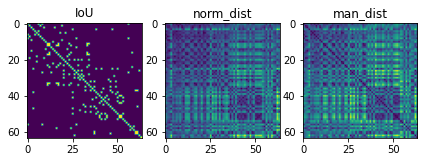

1.1


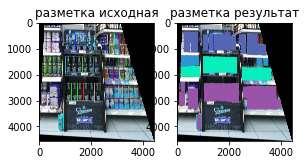

картинка :  /content/image_json/f3629039-af8c-4072-b956-32b77b762f0d_4.jpeg.json
число рамок на картинке:  89


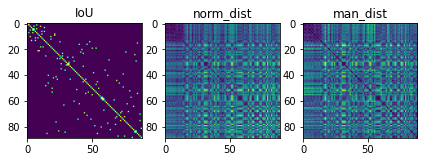

1


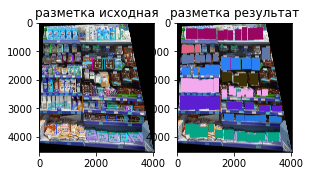

картинка :  /content/image_json/24d8bfc3-af64-4525-9dfc-bab6d1df6cbe_0.jpeg.json
число рамок на картинке:  88


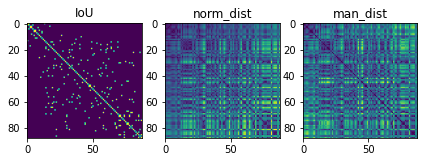

1


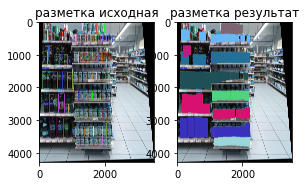

картинка :  /content/image_json/d3518d48-72d7-47f8-b334-4e61244c4378_0.jpeg.json
число рамок на картинке:  54


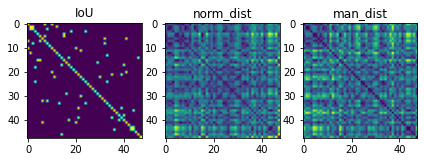

1


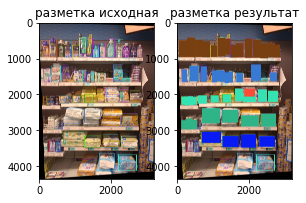

картинка :  /content/image_json/47532b0d-96bc-4589-983f-1e3e5700626a_1.jpeg.json
число рамок на картинке:  65


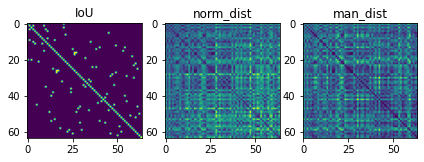

1


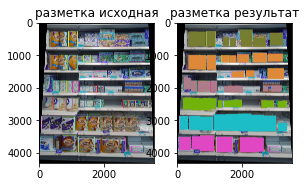

In [251]:
image_shape = []
numb_bound = []
verbose = 1
W = 30
# Читаем картинки из списка
for image_name in jpeg_arr[:]:
  X = []
  # картинке ставим в соответствие аннотацию
  box_bound, image = annotation_read(image_name, json_arr)
  numb_bound.append(len(box_bound))
  # строим признаки 
  X,_ , box_bound_clear = feature_prep(box_bound,image, centr = True, wx=32, w = W)
  # строим метрики
  iou, n_dist,y_dist, yx_dist,m_dist = my_metric(X, W) 
  if verbose:
    
    plt.figure(figsize = (7,16))
    plt.subplot(1,3,1) 
    plt.imshow(iou<1)
    plt.title('IoU')
    
    plt.subplot(1,3,2)        
    plt.imshow(n_dist)
    plt.title('norm_dist')
    
    plt.subplot(1,3,3)
    plt.imshow(m_dist)
    plt.title('man_dist')
    plt.show()
  # кластер-анализ  
  L,img_label = claster_image(box_bound_clear, image , 
                  metric_dist =y_dist/2+m_dist*0+iou*0.5, e_ps = 1, e_ps_max = 100, im_proc = 0.03,  verbose = 1)































## Результат 

сравнительно прилично выглядит:
- нужно брать метрику в смысле постоянства разметки
- Можно сделать еще какие-то настройки алгоритма вдоль его гиперпараметров (числа точек вне кластеров (сейчас 10% не более) и расширения области(w))



In [252]:
#iou*kw[0]+ n_dist*kw[1]+y_dist*kw[2]+yx_dist*kw[3]+m_dist*kw[4]
def image_clast(image_name, json_arr, verbose = 0, w = 30, centr = True, wx=32, e_ps = 1, e_ps_max = 100, im_proc = 0.1, kw = [4,0,0.5,0,1]):
  '''
  полный цикл для кластер- анализа
  вход:
  image_name - имя картинки, json_arr - имя аннотации, verbose = 0, w = 15
  
  centr = True - строим картинки для данных из центроида (или False - из рамки ), 
  wx - размер половины картинки по любой оси
  w - число пикселей на расширение рамки в стороны  
   
  гиперпараметры алгоритма
  e_ps = 3, e_ps_max = 30 - по DBSCAN,
  im_proc = 0.1 - часть не отнесенных к кластерам картинок,  
  
  verbose = 1 - визуализировать результат (0 - не визуализировать)

  Строим признаки:
  Х массив векторов в составе:
   - центроиды (сх, су)
   - коробка из данных json (BoundingBox)
   - Размеры по Х, У (ширина , высота)
  I - картинка вокруг центроида (centr = True) или в рамке из box_bound (centr = Falce)
  L - разметка по кластеранализу
  iou,n_dist,m_dist - метрики 
  box_bound_clear - рамки
  
  ''' 
  X = []
  I = []
  
  # картинке ставим в соответствие аннотацию
  box_bound, image = annotation_read(image_name, json_arr)
  
  # строим признаки 
  X,I, box_bound_clear = feature_prep(box_bound,image, centr = centr, wx=wx, w = w)
  # строим метрики
  #iou, n_dist, m_dist = my_metric(X, w) 
  iou, n_dist,y_dist, yx_dist,m_dist = my_metric(X, w) 
  if verbose == 2:
    
    plt.figure(figsize = (7,16))
    plt.subplot(1,3,1) 
    plt.imshow(iou<1)
    plt.title('IoU')
    
    plt.subplot(1,3,2)        
    plt.imshow(n_dist)
    plt.title('norm_dist')
    
    plt.subplot(1,3,3)
    plt.imshow(m_dist)
    plt.title('man_dist')
    plt.show()
  # кластер-анализ  
  L,img_label = claster_image(box_bound_clear, image , 
                  metric_dist =iou*kw[0]+ n_dist*kw[1]+y_dist*kw[2]+yx_dist*kw[3]+m_dist*kw[4], e_ps = e_ps, 
                  e_ps_max = e_ps_max, im_proc = im_proc,  verbose = verbose)
  #L,img_label = claster_image(box_bound_clear, image , 
  #                            metric_dist =m_dist+n_dist+iou, 
  #                            e_ps = e_ps, e_ps_max = e_ps_max, 
  #                            im_proc = im_proc,  
  #                            verbose = verbose)
  return  X, I, L, iou,n_dist,m_dist, box_bound_clear


Проверяем работу процедуры:
 - сеточный поиск коэффициентов метрик
 - проверка адекватности разметки (визуальная)

In [253]:

WX = 32
W = 30
#KW = [2,6,0.5,0.5,1]
#KW = [2,1.5,4,0.7,1.3]
KW = [1.5,0,10,0,0.1]

W: 30   : KW:  [1.5, 0, 10, 0, 0]
картинка :  /content/image_json/2df842e3-2a23-46f0-8ef5-4e4806cfb92e_0.jpeg.json
число рамок на картинке:  64
15.999999999999961


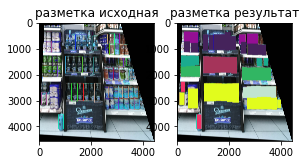

W: 30   : KW:  [1.5, 0, 10, 0, 0]
картинка :  /content/image_json/f3629039-af8c-4072-b956-32b77b762f0d_4.jpeg.json
число рамок на картинке:  89
12.799999999999972


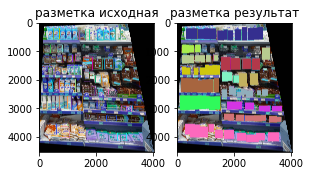

W: 30   : KW:  [1.5, 0, 10, 0, 0]
картинка :  /content/image_json/24d8bfc3-af64-4525-9dfc-bab6d1df6cbe_0.jpeg.json
число рамок на картинке:  88
13.099999999999971


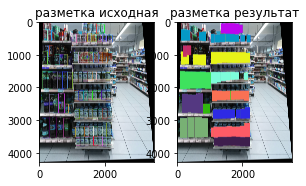

W: 30   : KW:  [1.5, 0, 10, 0, 0]
картинка :  /content/image_json/d3518d48-72d7-47f8-b334-4e61244c4378_0.jpeg.json
число рамок на картинке:  54
16.59999999999997


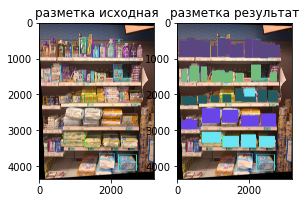

W: 30   : KW:  [1.5, 0, 10, 0, 0]
картинка :  /content/image_json/47532b0d-96bc-4589-983f-1e3e5700626a_1.jpeg.json
число рамок на картинке:  65
12.299999999999974


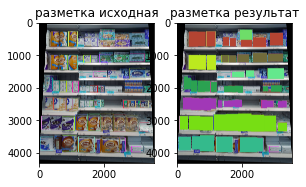

In [255]:
#iou*kw[0]+ n_dist*kw[1]+y_dist*kw[2]+yx_dist*kw[3]+m_dist*kw[4]
image_shape = []
numb_bound = []
image_shape = []
numb_bound = []
ar = [jpeg_arr[1],jpeg_arr[2]]
for image_name in jpeg_arr:
#image_name = jpeg_arr[2]
#W = 30
#  for i in [0.10, 0.5, 0.7, 1, 2, 3 , 6, 10]:
    KW = [1.5,0,10,0,0]
    print('W:',W,'  : KW: ' , KW)

    X,I,L, _,_,_,_ =image_clast(image_name, json_arr, verbose = 1, wx = WX, w = W, kw = KW , e_ps_max=300, im_proc=0.02)



Работает прилично, однако это практически результат проверки на тренировочном наборе

Используем эту разметку для обучения нейроннной сети


# Решение 2

Построим альтернативу более сложного вида:
- обучим нейросетевой эмбединг на сиамской сети
- в качестве данных на вход будем брать не только рамки, центроиды и перекрытия, но и сами изображения в рамках (похоже, что содержание картинки имеет смысл учесть)


## Нейронная сеть:
 - 2 входа: вектор Х = <центроид, рамка, размеры рамки >, I = <картинки внутри рамки, выровнена 64х64х3 и  нормализована к [0:1]> 

In [136]:
EMB_SIZE = 50
im_size = I[0].shape
def net_creat(EMB_SIZE = 50, im_size = (64,64,3), layer = [5,3]):
  # поток1 I
  inp_x_im = tf.keras.layers.Input(shape=(im_size[0], im_size[1], im_size[2]))
  inp_X = tf.keras.layers.Input(shape = (X.shape[1],))
  x1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inp_x_im)
  for k in range(layer[0]):
    x1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(x1)
    
  x1 = tf.keras.layers.Flatten()(x1)
  # поток2 Х 
  x2 = tf.keras.layers.Dense(256, activation='relu')(inp_X)
  for k in range(layer[1]):
    x2 = tf.keras.layers.Dense(256 // (k+1), activation='relu')(inp_X)

  x = tf.keras.layers.Concatenate(axis = 1)([x2,x1])
  x = tf.keras.layers.Dense(256, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(EMB_SIZE, activation=None)(x)

  return tf.keras.models.Model( inputs =[inp_x_im,inp_X], outputs = x)  

In [137]:
model = net_creat(EMB_SIZE = EMB_SIZE, im_size = (WX*2,WX*2,3), layer = [4,0])

In [138]:
im_size

(64, 64, 3)

In [139]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 64, 64, 32)   896         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 64, 64, 64)   18496       conv2d_18[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 64, 64, 64)   36928       conv2d_19[0][0]                  
____________________________________________________________________________________________

Настраиваемые гиперпараметры:
 - размер эмбединга
 - размер картинки на входе
 - число слоев
 - размер зазора

## Обучение нейронной сети

Обучаем на разметке из кластер-анализа

In [177]:
NUM_EPOCHS =10 # число эпох 
NUM_BATCH = 40 # число пакетов

LEARNING_RATE = 0.001 # скорость обучения

# оптимизатор
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
# зазор
MARGIN = 100.0


In [141]:

# пакеты для обучения - просто случайные индексы из текущего набора рамок
def data_XIL(L, batch_size = 8, N = 100):
  '''
  Половина пакета заполняется совсем случайно, 
  а вторая половина каждого пакета содержит одну из меток 
  (для балансировки классов похожих и нет объектов)
  L - метки от кластеризации, 
  batch_size = 8 - размер половины пакета (так обеспечим четность, что бы ни подали), 
  N = 100 - число пакетов

  вернем:
  ind - список из N  списков по batch_size индексов из возможных в L

  '''
  ind_k = L.max() + 1 # число классов
  K = np.random.randint(0,ind_k,(N,1))
  for i in range(N):
    while np.sum(L == K[i])<4:
      K[i] = np.random.randint(0,ind_k,(1))
  
  M = [np.random.choice(np.where(L == K[i])[0],(1,10))[0] for i in range(N)]
  
  #  в каждой строке будет много одинаковых индексов для балансировки
  ind = np.random.randint(0,len(L),size = ( N, batch_size) )
  ind = np.hstack([ind, M])
  ind = np.random.permutation(ind.T).T
  
  return ind


In [142]:


# https://www.pyimagesearch.com/2021/01/18/contrastive-loss-for-siamese-networks-with-keras-and-tensorflow/
# Функция потерь
def contastive_loss(embs, labels):
  # print(embs,labels)
  bs = embs.shape[0]
  embs1 = embs[:bs//2, :]
  embs2 = embs[bs//2:, :]
  
  labels1 = labels[:bs//2]
  labels2 = labels[bs//2:]
  #print(labels1,labels2)
  d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
  d =  tf.sqrt(d2)
  z = tf.cast(labels1 == labels2, tf.float32)
    
    
  return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

In [143]:
# обучение сиамской сети

def train_step(model, I,X,L, ind, hist):
  '''
  Реализация одного шага обучения (для одной картинки по всем ее рамкам )
  model - модель, 
  I,X,L - признаки и метки, 
  ind - индексы для пакета
  '''
  for iteration,ind_iter  in enumerate(ind):
    #print(ind_iter)
    # Forward
    with tf.GradientTape() as tape:
        
        embs = model([ I[ind_iter,:,:,:],X[ind_iter,:]])
        #print(embs.numpy())
       
        loss_value = contastive_loss(embs, L[ind_iter])
       
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    hist.append(loss_value.numpy())
    if iteration % 20 == 0:
        if loss_value.numpy()!=0:
            print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))
  return model, hist            

In [144]:
image_shape = []
numb_bound = []
image_shape = []
numb_bound = []
hist = []

In [268]:
# применим обучение модели для следующих эпох
for ch in range(NUM_EPOCHS):
  for image_name in jpeg_arr[:-1]:
    X,I,L, _,_,_,_ =image_clast(image_name, json_arr,  wx = WX, w = W, verbose = 0, kw = KW, im_proc=0.02, e_ps_max=300)
    ind = data_XIL(L,batch_size = 16, N = NUM_BATCH )
    model, hist = train_step(model, I,X,L, ind, hist)


картинка :  /content/image_json/2df842e3-2a23-46f0-8ef5-4e4806cfb92e_0.jpeg.json
число рамок на картинке:  64
15.999999999999961
[0] Loss: 242.11219787597656
[20] Loss: 307.67449951171875
картинка :  /content/image_json/f3629039-af8c-4072-b956-32b77b762f0d_4.jpeg.json
число рамок на картинке:  89
12.799999999999972
[0] Loss: 550.279541015625
[20] Loss: 18.760725021362305
картинка :  /content/image_json/24d8bfc3-af64-4525-9dfc-bab6d1df6cbe_0.jpeg.json
число рамок на картинке:  88
13.099999999999971
[0] Loss: 27.482501983642578
[20] Loss: 73.63082885742188
картинка :  /content/image_json/d3518d48-72d7-47f8-b334-4e61244c4378_0.jpeg.json
число рамок на картинке:  54
16.59999999999997
[0] Loss: 519.0397338867188
[20] Loss: 101.21994018554688
картинка :  /content/image_json/2df842e3-2a23-46f0-8ef5-4e4806cfb92e_0.jpeg.json
число рамок на картинке:  64
15.999999999999961
[0] Loss: 629.3775024414062
[20] Loss: 52.28011703491211
картинка :  /content/image_json/f3629039-af8c-4072-b956-32b77b762f0

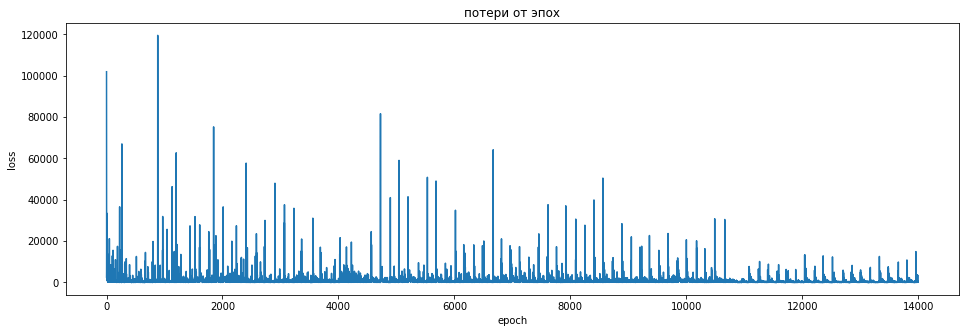

In [269]:
plt.figure(figsize = (16,5))
plt.plot(hist)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('потери от эпох')
plt.show()

Кривая обучения не выглядит интересной - даже с учетом обучения на метрик ленинг, но прилично

## Тестирование

Сделаем тест для последней картинки

In [270]:
emb=[]
lab=[]

# так ее разметил кластеранализ (не все полки в одну строку)

image_name = jpeg_arr[-1]
X,I,L, _,_,_,_ =image_clast(image_name, json_arr, verbose = 0, wx = WX)
# построили входные данные для сети 
for iteration in range(len(L)):
  sample = [I[iteration:iteration+1,:],X[iteration:iteration+1,:]]
  emb.append(model.predict(sample)) #передали данные в сеть
  lab.append(L[iteration])

картинка :  /content/image_json/47532b0d-96bc-4589-983f-1e3e5700626a_1.jpeg.json
число рамок на картинке:  65
48.70000000000042


In [271]:
# вычисление метрики для вложеня (Euqlid)
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

# вычисление пар по меткам
#for i in range(len(L)-1):
#  for j in range(i+1,len(L)): 
#    if (lab[j] != -1) & (lab[i] != -1):
#      print(lab[i],' <-> : ',lab[j], ' : ', diff(emb[i], emb[j]))


In [272]:
# метрики по эмбелингу (вложению)
def my_embed_metric(X):
  net_dist = np.ones((X.shape[0],X.shape[0])) # нормированное расстояние - инициализация 1(пока)
  for i in range(X.shape[0]-1):
    for j in range(i+1,X.shape[0]):
      net_dist[i,j] = diff( X[i,2:6],X[j,2:6])
      net_dist[j,i] =  net_dist[i,j]
      
  return net_dist# 


def image_clast_net(image_name='', json_name='', model=None,  w = 15, centr = True, 
                    wx=32, e_ps = 1,
                    e_ps_max = 100, im_proc = 0.1, verbose=1):
  '''
  полный цикл для кластер- анализа
  вход:
  image_name - имя картинки, json_arr - имя аннотации, verbose = 0, w = 15
  
  centr = True - строим картинки для данных из центроида (или False - из рамки ), 
  wx - размер половины картинки по любой оси
  w - число пикселей на расширение рамки в стороны  
   
  гиперпараметры алгоритма
  e_ps = 3, e_ps_max = 30 - по DBSCAN,
  im_proc = 0.1 - часть не отнесенных к кластерам картинок,  
  
  verbose = 1 - визуализировать результат (0 - не визуализировать)

  Строим признаки:
  Х массив векторов в составе:
   - центроиды (сх, су)
   - коробка из данных json (BoundingBox)
   - Размеры по Х, У (ширина , высота)
  I - картинка вокруг центроида (centr = True) или в рамке из box_bound (centr = Falce)
  L - разметка по кластеранализу
  iou,n_dist,m_dist - метрики 
  box_bound_clear - рамки
  
  ''' 
  X = []
  I = []
  
  # картинке ставим в соответствие аннотацию
  box_bound, image = annotation_read(image_name, json_arr)
  
  # строим признаки 
  X,I, box_bound_clear = feature_prep(box_bound,image, centr = centr, wx=wx, w = w)
  # строим метрики
  sample = [I,X]
  X_emb = model.predict(sample)
  n_emb = my_embed_metric(X_emb)
  #if verbose:
  #  
  #  plt.figure(figsize = (7,16))
  #   
  #  plt.imshow(n_emb)
  #  plt.title('Эмбединг')
    
  #  plt.show()
  # кластер-анализ  
  L,img_label = claster_image(box_bound_clear, image , 
                              metric_dist = n_emb, 
                              e_ps = e_ps, e_ps_max = e_ps_max, 
                              im_proc = im_proc,  
                              verbose = verbose)
  
  return  X, I, L, n_emb, box_bound_clear

Проверяем тестовый пример:

картинка :  /content/image_json/47532b0d-96bc-4589-983f-1e3e5700626a_1.jpeg.json
число рамок на картинке:  65
29.40000000000015


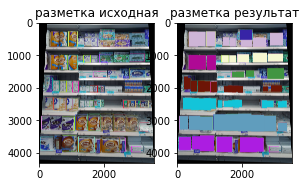

In [273]:
image_name = jpeg_arr[-1]
_,_,L,emb_,_=image_clast_net(image_name, json_arr, model=model, verbose = 1, w = W, wx=WX, im_proc = 0.03)

*Разметка по полкам*, : большая полка вверху +/- (есть объект отдельного кластера), большая полка внизу +/- (один объект не распределен), 6 полок в середине +
Проверим картинки, которые использовали в обучении:

картинка :  /content/image_json/2df842e3-2a23-46f0-8ef5-4e4806cfb92e_0.jpeg.json
число рамок на картинке:  64
43.00000000000034


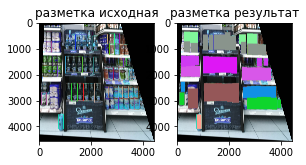

картинка :  /content/image_json/f3629039-af8c-4072-b956-32b77b762f0d_4.jpeg.json
число рамок на картинке:  89
31.100000000000176


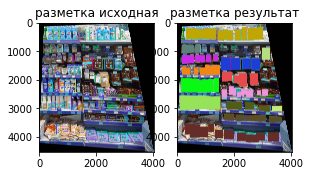

картинка :  /content/image_json/24d8bfc3-af64-4525-9dfc-bab6d1df6cbe_0.jpeg.json
число рамок на картинке:  88
15.999999999999961


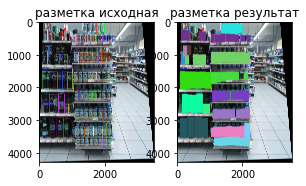

картинка :  /content/image_json/d3518d48-72d7-47f8-b334-4e61244c4378_0.jpeg.json
число рамок на картинке:  54
20.000000000000018


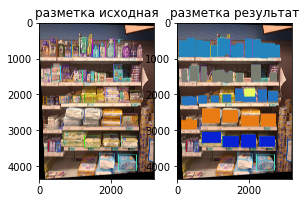

In [274]:
for image_name in jpeg_arr[:-1]:
  _,_,L,emb_,_=image_clast_net(image_name, json_arr, model=model, verbose = 1, w = W, wx=WX, im_proc = 0.03)

 - 0 я картинка:  есть пропущенные объекты, ряды определились, но полки соедининены по стелажам (самая плохая картинка)
 - 1я ряды почти без ошибок
 - 2я не различила передний стелаж и дальний (как и в 0-й)
 - 3я одна ошибка группировки (на третьей полке есть небольшой доп кластер) и 2 объекта самой нижней частичновидимой полки не размечены


## Результат 

сравнительно прилично выглядит:
- нужно брать метрику в смысле постоянства разметки
- Можно сделать еще какие-то настройки алгоритма вдоль его гиперпараметров (числа точек вне кластеров (сейчас 10% не более) и расширения области(w))
- сохраним модель для работы 




In [276]:
model.save_weights('siam_net.h5')